<a href="https://colab.research.google.com/github/nameera-khan/Machine-learning-projects/blob/main/Instagram_reach_forecasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualisation
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualisation
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
df = pd.read_csv('Instagram-Reach.csv')
df.head()

,Date,Instagram reach
0,2022-04-01T00:00:00,7620
1,2022-04-02T00:00:00,12859
2,2022-04-03T00:00:00,16008
3,2022-04-04T00:00:00,24349
4,2022-04-05T00:00:00,20532


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             365 non-null    datetime64[ns]
 1   Instagram reach  365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
training_data_len = math.ceil(len(df)*0.8)

In [8]:
training_data_len = math.ceil(len(df) * .8)
training_data_len

#Splitting the dataset
train_data = df[:training_data_len].iloc[:,:1]
test_data = df[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(292, 1) (73, 1)


In [11]:
train_data['Instagram reach'] = train_data.rename({'Instagram reach':'reach'})

In [18]:
data = df[['Date', 'Instagram reach']]


In [19]:
# Convert 'Instagram reach' to numpy array
dataset = data['Instagram reach'].values.reshape(-1, 1)

In [20]:
# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(dataset)


In [23]:
# Convert to PyTorch tensor
dataset_normalized = torch.FloatTensor(data_scaled).view(-1)

In [24]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length:i + seq_length + 1]
        sequences.append((seq, label))
    return sequences

#set sequence length
sequence_length = 10  # You can adjust this based on your data


In [25]:
sequences = create_sequences(dataset_normalized, sequence_length)


In [26]:
train_size = int(len(sequences) * 0.8)
test_size = len(sequences) - train_size
train_data, test_data = sequences[0:train_size], sequences[train_size:len(sequences)]


In [27]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Instantiate the model, set loss function and optimizer
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

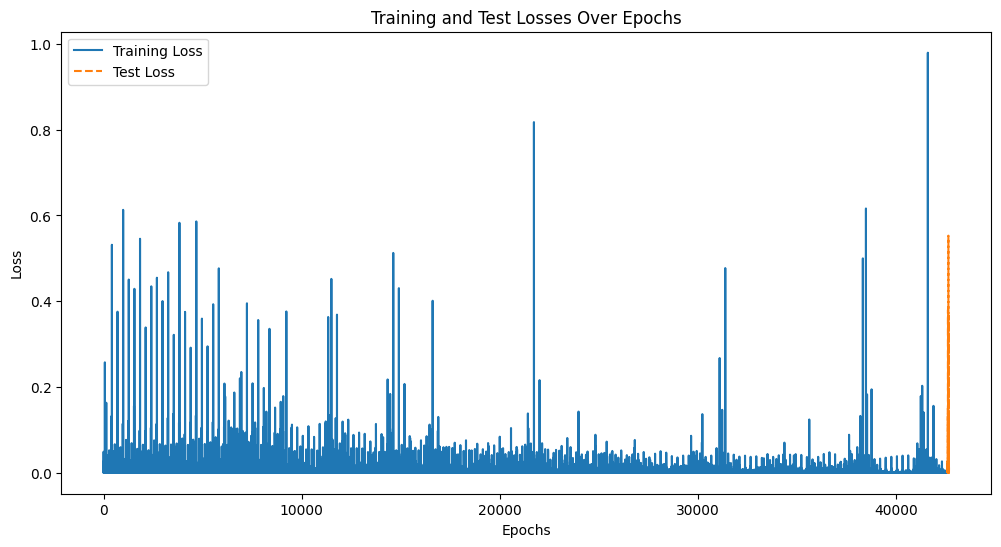

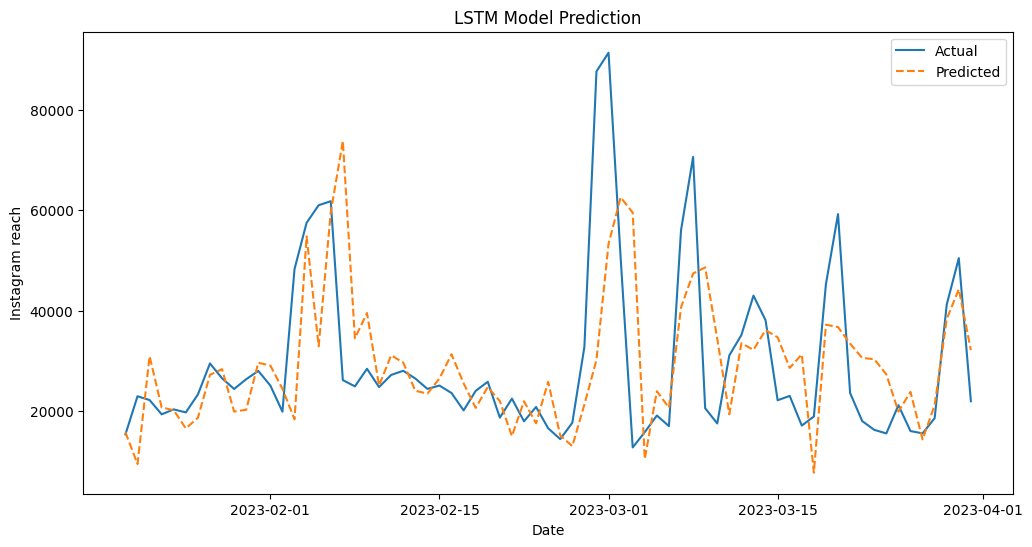

In [29]:
# Train the model
epochs = 150
train_losses = []
for i in range(epochs):
    for seq, labels in train_data:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

        train_losses.append(single_loss.item())  # Record training loss


#test the model
model.eval()
test_losses = []
for seq, labels in test_data:
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_loss = loss_function(model(seq), labels)
        test_losses.append(test_loss.item())

# Plot the training and test losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(len(train_losses), len(train_losses) + len(test_losses)), test_losses, label='Test Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Losses Over Epochs')
plt.legend()
plt.show()

# Inverse transform the predictions to original scale
predicted_data = []
for seq, _ in test_data:
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        predicted_data.append(model(seq).item())

predicted_data = scaler.inverse_transform(np.array(predicted_data).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data['Date'][-len(predicted_data):], data['Instagram reach'][-len(predicted_data):], label='Actual')
plt.plot(data['Date'][-len(predicted_data):], predicted_data, label='Predicted', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Instagram reach')
plt.title('LSTM Model Prediction')
plt.legend()
plt.show()

In [33]:
test_losses[-1]

0.017371678724884987

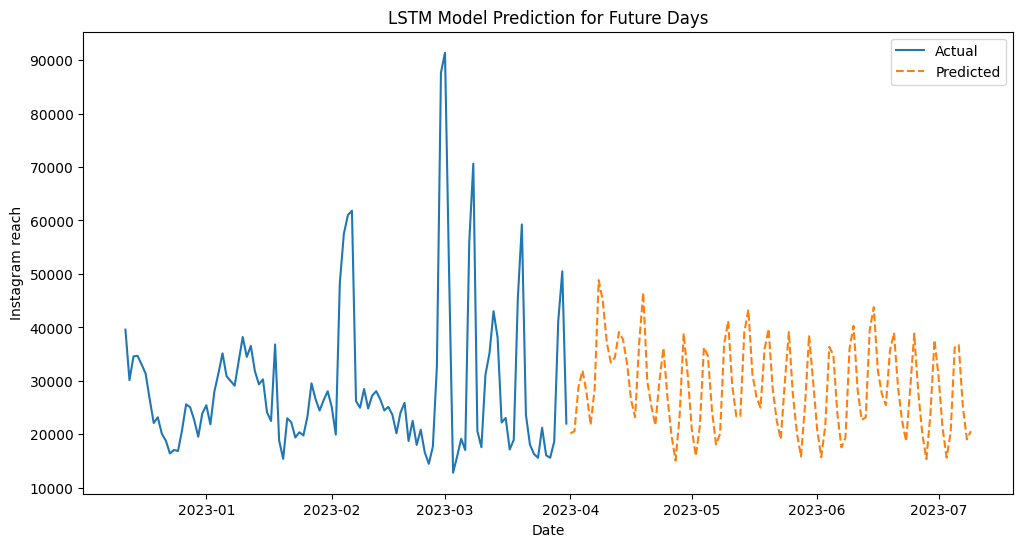

In [37]:
# Predict future days
future_days = 100  # Number of days to predict
prediction_seq = dataset_normalized[-sequence_length:].tolist()  # Start with the last sequence from the dataset

model.eval()

for _ in range(future_days):
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        input_seq = torch.FloatTensor(prediction_seq[-sequence_length:])
        prediction = model(input_seq)
        prediction_seq.append(prediction.item())

# Inverse transform the predictions to the original scale
predicted_data = scaler.inverse_transform(np.array(prediction_seq).reshape(-1, 1))
# Create future date range for plotting
last_date = data['Date'].iloc[-1]
future_date_range = pd.date_range(last_date + pd.DateOffset(1), periods=future_days)
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data['Date'][-len(predicted_data):], data['Instagram reach'][-len(predicted_data):], label='Actual')
plt.plot(future_date_range, predicted_data[-future_days:], label='Predicted', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Instagram reach')
plt.title('LSTM Model Prediction for Future Days')
plt.legend()
plt.show()

- LSTM is a type of neural network that can capture complex, non-linear patterns in the data. It is capable of learning intricate relationships and dependencies, making it suitable for time series with non-linear and dynamic behaviors.

- LSTMs can automatically learn relevant features from the data, which can be beneficial when dealing with high-dimensional and complex time series.

- SARIMA models are based on well-established statistical principles and have interpretable parameters. This can be advantageous when you need a transparent understanding of the factors influencing the time series.



